In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform
#import SIRD_Model_Experimental
import SIRD_Model
from sklearn import linear_model


# Determining Beta At Time t

# $\beta_{t} = \sigma_{t} \cdot \frac{q \cdot Pop + \tilde I_{C(t)} - \tilde Z_{t}}{\tilde I_{C(t)} (q \cdot Pop - \tilde Z_{t})} \cdot \tilde Z_{t} $ 

# All Current Files Start at March 7 and end at December 31

In [44]:
def getGamma(infect, dead):
    
    recovG = approxRecovered(infect)
    infect = infect - recovG - dead
    infect = infect[:-1].reshape((len(infect[:-1]),1))
    recovGD = np.diff(recovG)
    recovGD - recovGD.reshape((len(recovGD),1))

    gamma = np.linalg.lstsq(infect, recovGD, rcond = None)[0][0]
    return gamma

def getNu(infect, dead):
    
    recovG = approxRecovered(infect)
    infect = infect - recovG - dead #current infected
    infect = infect[:-1].reshape((len(infect[:-1]),1))
    deadD = np.diff(dead)
    deadD - deadD.reshape((len(deadD),1))

    nu = np.linalg.lstsq(infect, deadD, rcond = None)[0][0]
    return nu

def approxRecovered(infect):
    recovG = np.zeros(len(infect))
    for i in range(len(infect) - 13):
        recovG[i + 13] = infect[i] - dead[i + 13]
    return recovG


def getBeta(pop, q, infect, dead):
    
    winSize = 13
    sigma = regressionSlopeSeries(infect, winSize )
    recov = approxRecovered(infect)
    infectN = infect - recov - dead
    Z = infect 
    Zt = Z 
    It = infectN 
    halfwin = winSize // 2
    Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]
    
    fig,ax = plt.subplots(figsize = (18,8))
    ax.plot(sigma, '.', color = 'red')
    ax.set_title("Sigma (Estimated Derivative) Over Time")
    
    return Beta
    
    
def getRegressionSlope(points):
    """
    Takes a given number of points and outputs slope determined by linear regression
    Times can be included, if they are not, the indexes are assumed to be the times, starting from 0
    """
    timeArray = np.ones((len(points), 2))
    timeArray[:,1]  = np.arange(len(points))
    pointArray = np.array(points)
    point_slope, res, _, _ = np.linalg.lstsq(timeArray, np.log(pointArray), rcond=None)
    slope = point_slope[1]
    return slope

def regressionSlopeSeries(points, window):
    """
    Given a series of points and a window size, estimates the slope at each point
    Outputs both the estimated slopes and regression errors for all applicable points
    If times list is provided, each of the included times should match up respectively with the points
    Window should be odd, if it isn't it will automatically be interpreted as one larger than the argument passed
    """
    # cut the window in half so we know how long it extends on both sides
    half_window = window//2
    num_points = len(points)
    slopes = []

    for i in range(num_points):
        # if there are not enough previous values to satisfy window size, continue
        if i < half_window:
            continue
        # if there are not enough values after the current one to satisfy window size, break
        if num_points-i <= half_window:
            break
        slope = getRegressionSlope(points[i-half_window: i+half_window])
        slopes.append(slope)

    slopes = np.array(slopes)
    return slopes

def getOandC(filename):
    O = []
    C = []
    
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
    for i in range(len(aData)):
        if(aData[i][1] == "Closure"):
            C.append(aData[i][0])
        if(aData[i][1] == "Opening"):
            O.append(aData[i][0])
    return O,C

def displayOandC(filename, beta, ax, dates):
    #Add or modify dates for closures or openings here
    

    Opening, Closure = getOandC(filename)

    Oind = []
    Cind = []

    temp = dates.tolist()
    #Get the indexes for each opening or closing date
    for i in range(len(Opening)):
        Oind.append(temp.index(Opening[i]))
    for i in range(len(Closure)):
        Cind.append(temp.index(Closure[i]))

    
    #Variables used to fix legend duplications
    temp1 = 0
    temp2 = 0

    #Add the dashed lines going up to the beta curve
    for i in range(len(Oind)): 
        if(temp1 == 0):
            plt.vlines(x = Oind[i],color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[Oind[i]], label = "Openings")
            temp1 = 1
        else:
            plt.vlines(x = Oind[i],color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[Oind[i]] )
    for i in range(len(Cind)):
        if(temp2 == 0):
            plt.vlines(x = Cind[i],color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[Cind[i]], label = "Closures")
            temp2 = 1
        else:
            plt.vlines(x = Cind[i],color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[Cind[i]])
    ax.legend(fontsize=20)

In [74]:
#predict the next some days using constant parameters
def calculateFuture(infect, recov, dead, pop, daysToPredict, params, q):
    
    #A=sirdmatrix, and dt=nextIterMatrix, if we know S(t) we should be able to predict S(t+1)
    suscept = q*pop - infect - recov - dead
    dt, A = SIRD_Model.getSIRDMatrices(suscept, infect, recov, dead)

    sirdPredict = np.zeros((len(A) + daysToPredict, 4, 3))
    dtPredict = np.zeros((len(dt) + daysToPredict, 4, 1))

    sirdPredict[0:len(A)] = A
    dtPredict[0:len(dt)] = dt

    susceptPredict = np.zeros(len(suscept) + daysToPredict)
    infectPredict = np.zeros(len(infect) + daysToPredict)
    recovPredict = np.zeros(len(recov) + daysToPredict)
    deadPredict = np.zeros(len(dead) + daysToPredict)

    susceptPredict[0:len(suscept)] = suscept
    infectPredict[0:len(infect)] = infect
    recovPredict[0:len(recov)] = recov
    deadPredict[0:len(dead)] = dead

    T = len(suscept)
    for t in range(T-1, T + daysToPredict - 1): #go from last element in known list to end of prediction, see paper for method
        #populate the 4x3 matrix with parameters
        sirdPredict[t,0,0] = -(susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])
        sirdPredict[t,1,0] = (susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])
        sirdPredict[t,1,1] = -infectPredict[t]
        sirdPredict[t,1,2] = -infectPredict[t]
        sirdPredict[t,2,1] = infectPredict[t]
        sirdPredict[t,3,2] = infectPredict[t]

        #find next dtPredict
        dtPredict[t,:,0] = (sirdPredict[t] @ params)

        #find next SIRD, based on dtPredict[t] (which is S(t+1) - S(t)) to predict S(t) (and so on)
        susceptPredict[t+1] = susceptPredict[t] + dtPredict[t,0,0]
        infectPredict[t+1] = infectPredict[t] + dtPredict[t,1,0]
        recovPredict[t+1] = recovPredict[t] + dtPredict[t,2,0]
        deadPredict[t+1] = deadPredict[t] + dtPredict[t,3,0]
    
    return susceptPredict, infectPredict, recovPredict, deadPredict, q, params


#predict future days that are not known
def predictFuture(infect, recov, dead, pop, daysToPredict, param, qVal, graphVals=[True,True,True,True]):
    pS, pI, pR, pD, q, params = calculateFuture(infect, recov, dead, pop, daysToPredict, param, qVal)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphVals[0]):
        ax.plot(suscept, color='blue', label='suscpetible')
        ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    if(graphVals[1]):
        ax.plot(infect, color='orange', label='infected')
        ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    if(graphVals[2]):
        ax.plot(recov, color='green', label='recovered')
        ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    if(graphVals[3]):
        ax.plot(dead, color='black', label='dead')
        ax.plot(pD, color='black', label='dead', linestyle='dashed')

    
#predict days that are known for testing purposes, predicts the end portion of the given data
def predictMatch(infect, recov, dead, pop, daysToPredict, param, qVal, graphVals=[True,True,True,True]):
    pS, pI, pR, pD, q, params = calculateFuture(infect[0:-daysToPredict], recov[0:-daysToPredict], dead[0:-daysToPredict], pop, daysToPredict, param, qVal)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))

    if(graphVals[0]):
        ax.plot(suscept, color='blue', label='suscpetible')
        ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    if(graphVals[1]):
        ax.plot(infect, color='orange', label='infected')
        ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    if(graphVals[2]):
        ax.plot(recov, color='green', label='recovered')
        ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    if(graphVals[3]):
        ax.plot(dead, color='black', label='dead')
        ax.plot(pD, color='black', label='dead', linestyle='dashed')

# Texas

3/7/2020 3/7/2021


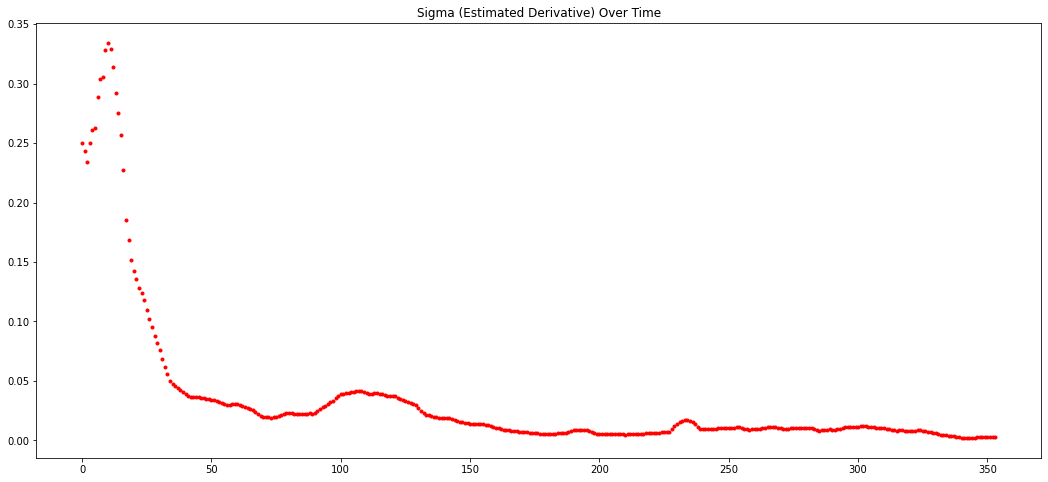

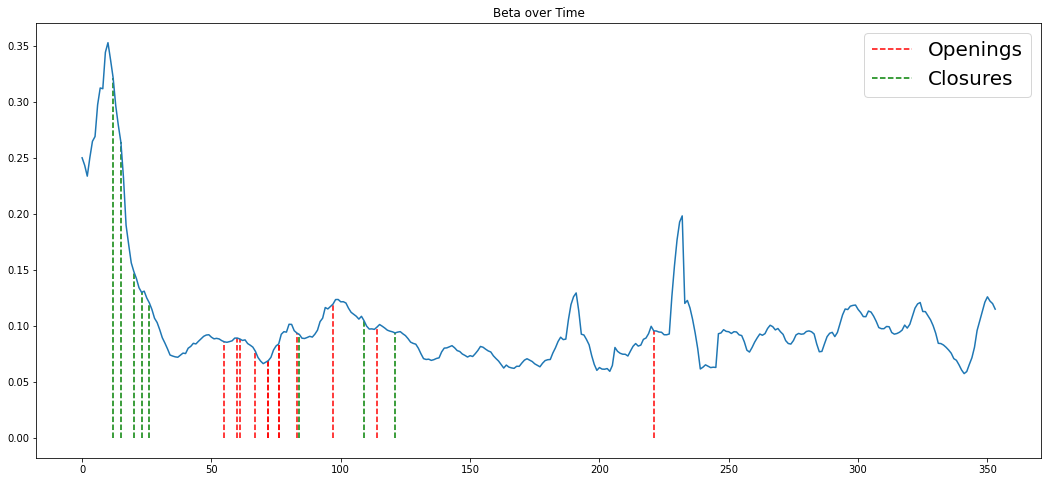

In [89]:
pathc="../Data/Covid Tracking State Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
#Change state abbreviation based on the state you want to use
filename = "TX.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

#Change population based on the state you want to use
pop = 29000000
numDays = len(infectRaw)
infect = infectRaw[0:numDays]
dead = deadRaw[0:numDays]

gamma = getGamma(infect,dead)
nu = getNu(infect,dead)
q = .1 #0.0754
beta = getBeta(pop, q, infect, dead)
#print(gamma, beta)

fig, ax = plt.subplots(figsize = (18,8))
ax.plot(beta)
ax.set_title("Beta over Time")
#plt.yscale("log")
print(dates[0],dates[-1])

pathc="../Data/State Closure Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
file = "Texas closure data.csv"
displayOandC(pathc + file, beta, ax, dates)

Open markers:  ['5/1/2020', '5/6/2020', '5/7/2020', '5/13/2020', '5/18/2020', '5/18/2020', '5/22/2020', '5/22/2020', '5/29/2020', '6/12/2020', '6/29/2020', '10/14/2020']
Close markers:  ['3/19/2020', '3/22/2020', '3/27/2020', '3/30/2020', '4/2/2020', '5/30/2020', '6/24/2020', '7/6/2020']

Enter start sim date: 
Start, Mid, End:  5/22/2020 5/30/2020 6/12/2020
beta before:  0.09483782133180502
beta after:  0.09924135440338103
[0.09924135440338103, 0.07489867271325439, 0.0011903193976931666]


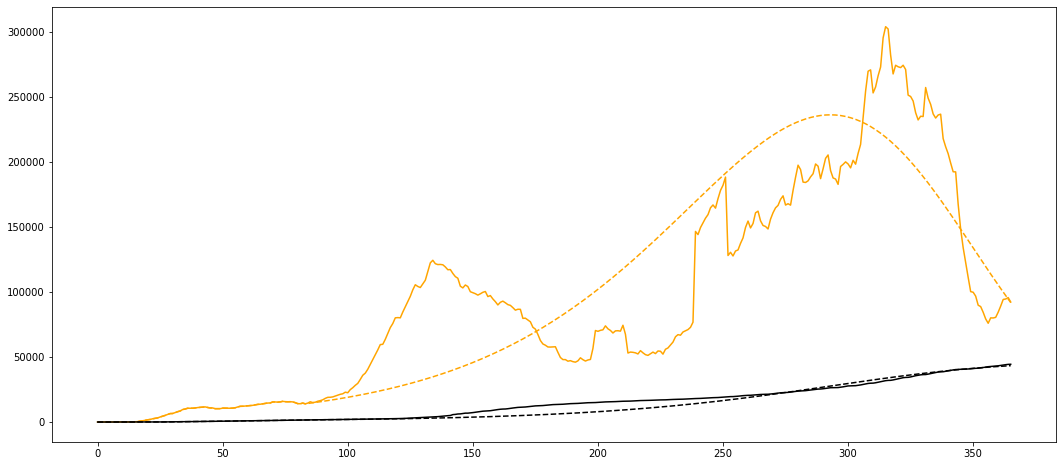

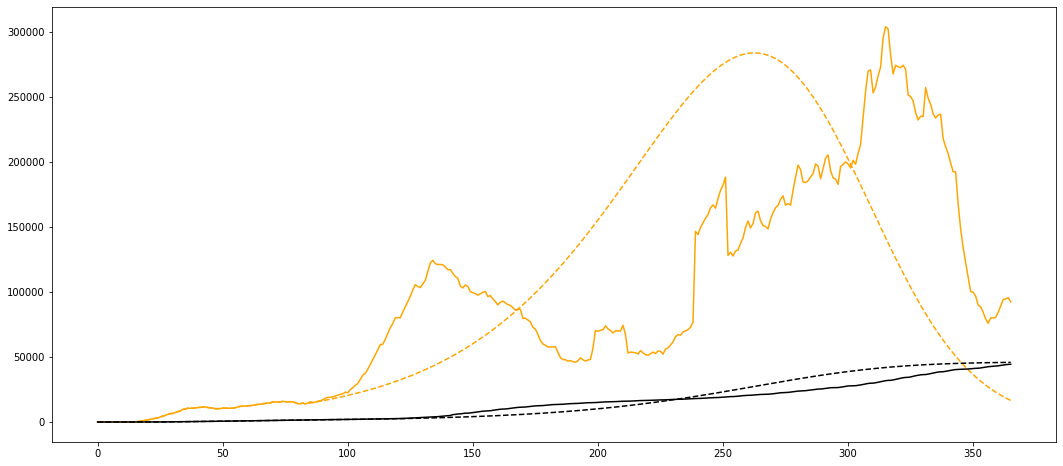

In [94]:
O,C = getOandC(pathc + file)

print("Open markers: ", O)
print("Close markers: ", C)
print()
print("Enter start sim date: ")
startDate = '5/22/2020'#dates[0]
#simDate = input()
simDate = '5/30/2020'
endDate = '6/12/2020'

temp = dates.tolist()
startInd = temp.index(startDate)
simInd = temp.index(simDate)
endInd = temp.index(endDate)


print("Start, Mid, End: ", startDate, simDate, endDate)
#print(startInd, simInd, endInd)
simBetaAfter = np.average(beta[simInd:endInd])
simBetaBefore = np.average(beta[startInd:simInd])
print("beta before: ", simBetaBefore)
print("beta after: ", simBetaAfter)


recov = approxRecovered(infect)
currInfect = infect - dead - recov
paramA = [simBetaAfter, getGamma(infect, dead), getNu(infect, dead)]
paramB = [simBetaBefore, getGamma(infect, dead), getNu(infect, dead)]

print(paramA)


predictMatch(currInfect, recov, dead, pop, (numDays - simInd), paramB, q, graphVals=[0,1,0,1])
predictMatch(currInfect, recov, dead, pop, (numDays - simInd), paramA, q, graphVals=[0,1,0,1])

# New York

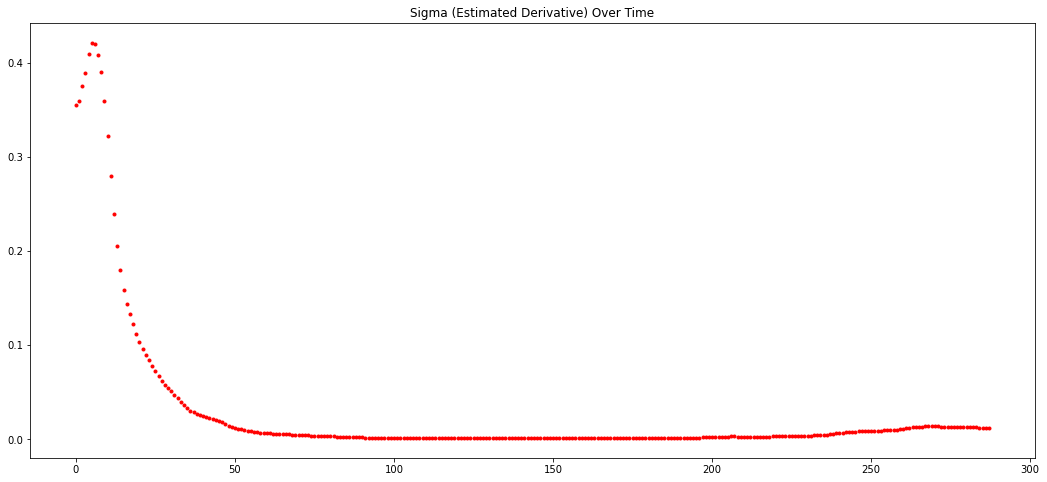

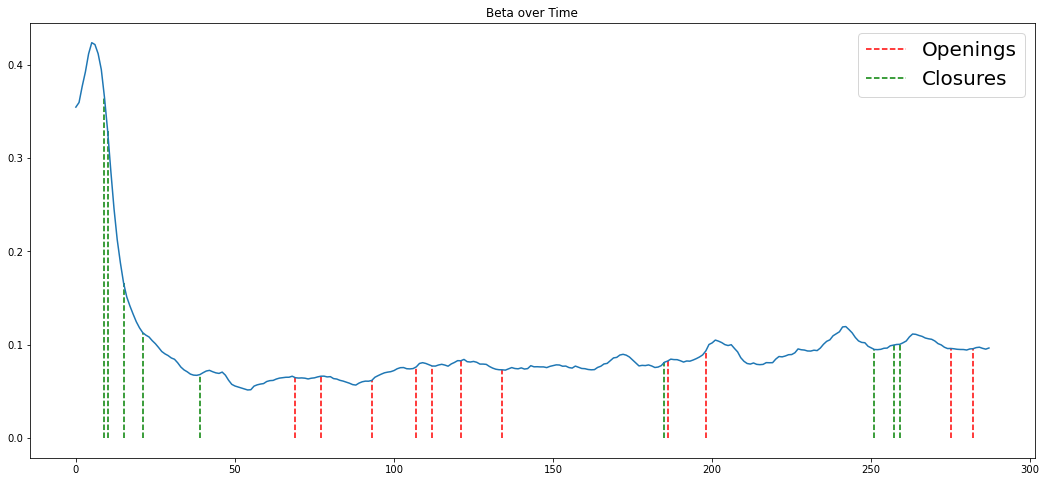

In [23]:
pathc="../Data/Covid Tracking State Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "NY.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

pop = 20201249
numDays = 300
daysToPredict = 30
infect = infectRaw[0:numDays]
dead = deadRaw[0:numDays]

gamma = getGamma(infect,dead)
q = .0754
beta = getBeta(pop, q, infect, dead)
#print(gamma, beta)

fig, ax = plt.subplots(figsize = (18,8))
ax.plot(beta)
ax.set_title("Beta over Time")
#plt.yscale("log")

path="../Data/State Closure Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    path.replace("/", "\\")

file = "New York Closure Data.csv"
displayOandC(path + file, beta, ax, dates)

# CA

<ipython-input-4-76db8df6c9e1>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  gamma = np.linalg.lstsq(infect, recovGD)[0]


Text(0.5, 1.0, 'Beta over Time')

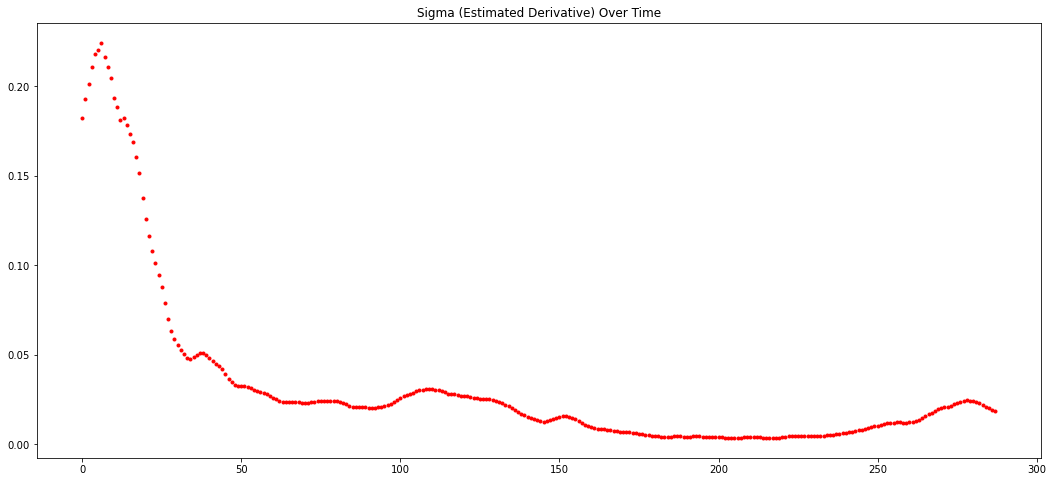

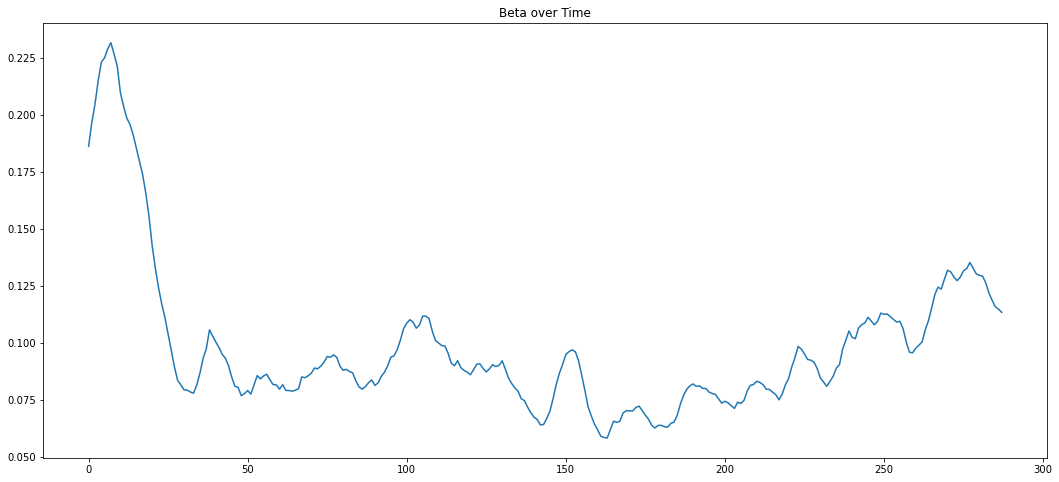

In [8]:
pathc="../Data/Covid Tracking State Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "CA.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

pop = 39510000
numDays = 300
daysToPredict = 30
infect = infectRaw[0:numDays]
dead = deadRaw[0:numDays]

gamma = getGamma(infect,dead)
q = .0754
beta = getBeta(pop, q, infect, dead)
#print(gamma, beta)

fig, ax = plt.subplots(figsize = (18,8))
ax.plot(beta)
ax.set_title("Beta over Time")
#plt.yscale("log")

# Florida

<ipython-input-4-76db8df6c9e1>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  gamma = np.linalg.lstsq(infect, recovGD)[0]


Text(0.5, 1.0, 'Beta over Time')

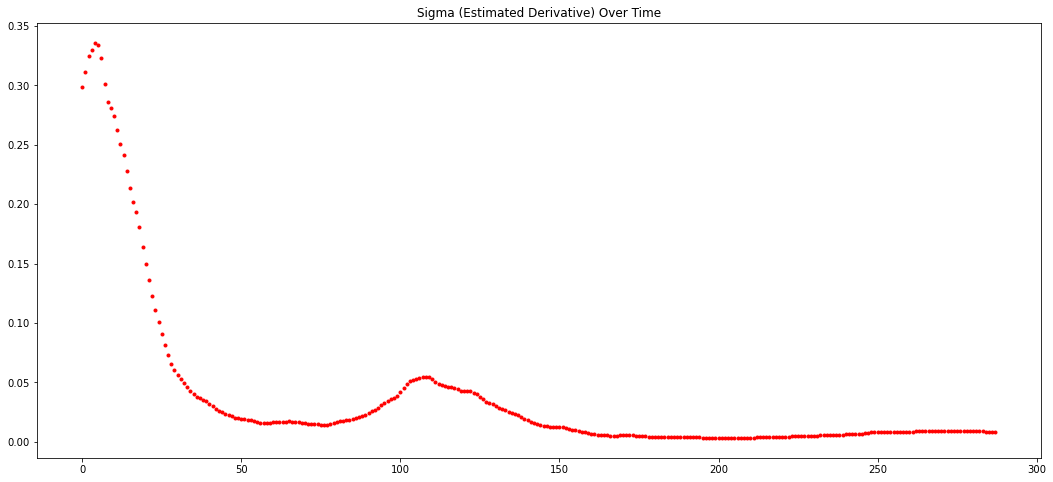

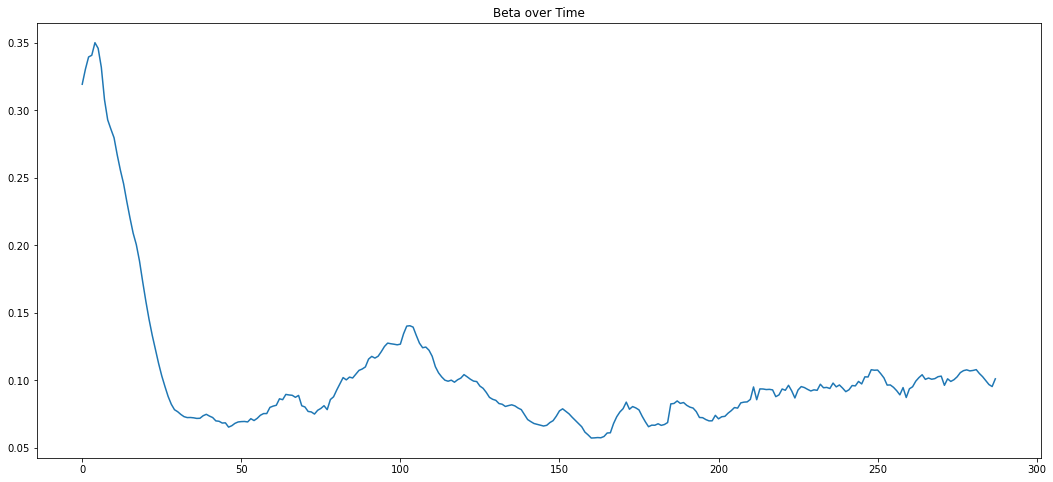

In [9]:
pathc="../Data/Covid Tracking State Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "FL.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

pop = 21480000
numDays = 300
daysToPredict = 30
infect = infectRaw[0:numDays]
dead = deadRaw[0:numDays]

gamma = getGamma(infect,dead)
q = 0.0754
beta = getBeta(pop, q, infect, dead)
#print(gamma, beta)

fig, ax = plt.subplots(figsize = (18,8))
ax.plot(beta)
ax.set_title("Beta over Time")
#plt.yscale("log")


# Arizona

<ipython-input-4-76db8df6c9e1>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  gamma = np.linalg.lstsq(infect, recovGD)[0]


Text(0.5, 1.0, 'Beta over Time')

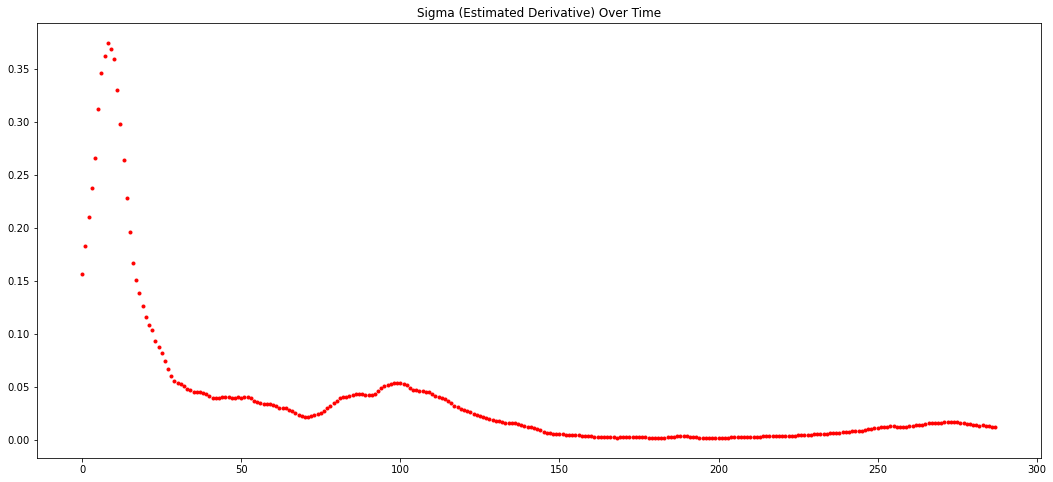

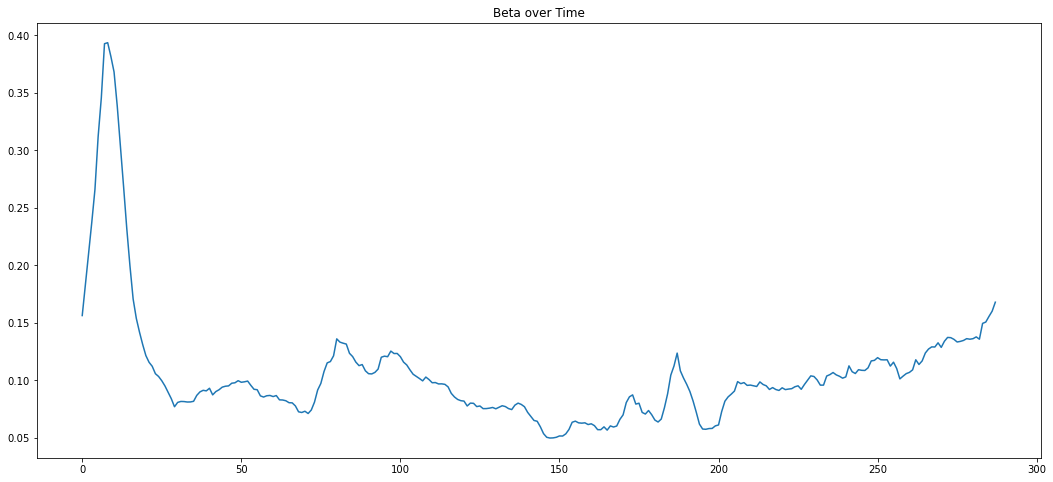

In [10]:
pathc="../Data/Covid Tracking State Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "AZ.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

pop = 7279000
numDays = 300
daysToPredict = 30
infect = infectRaw[0:numDays]
dead = deadRaw[0:numDays]

gamma = getGamma(infect,dead)
q = 0.0754
beta = getBeta(pop, q, infect, dead)
#print(gamma, beta)

fig, ax = plt.subplots(figsize = (18,8))
ax.plot(beta)
#ax.set_ylim([0,0.0001])
ax.set_title("Beta over Time")
#plt.yscale("log")

<ipython-input-3-76db8df6c9e1>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  gamma = np.linalg.lstsq(infect, recovGD)[0]


Text(0.5, 1.0, 'Beta over Time')

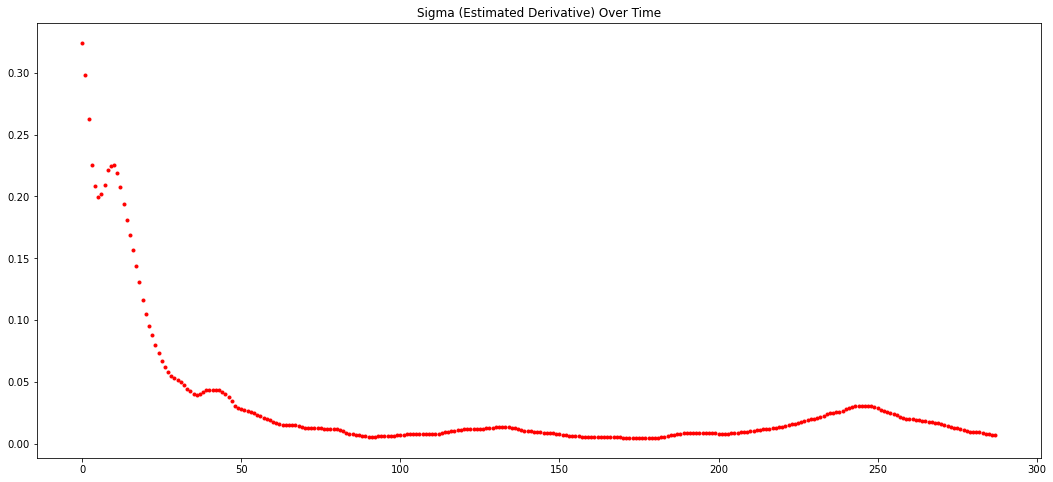

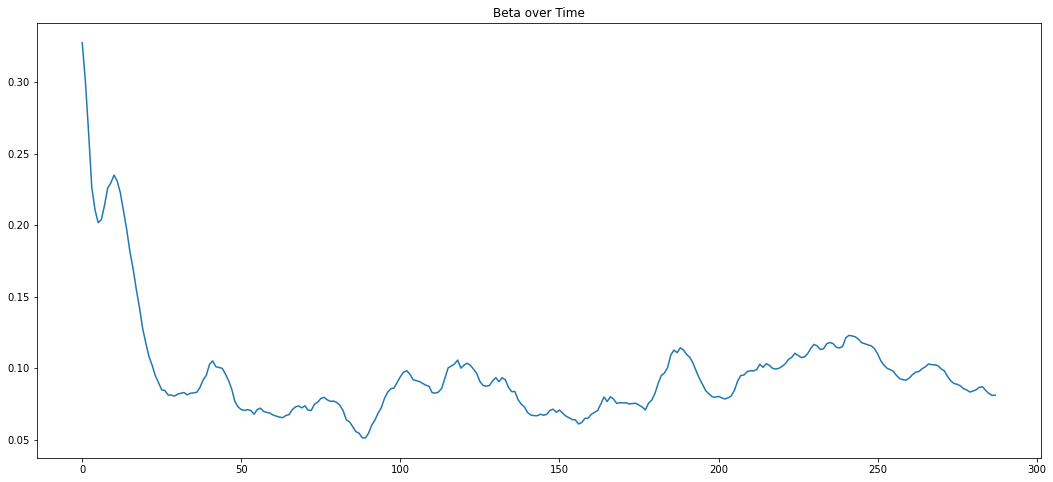

In [10]:
pathc="../Data/Covid Tracking State Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "CO.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

pop = 5759000
numDays = 300
daysToPredict = 30
infect = infectRaw[0:numDays]
dead = deadRaw[0:numDays]

gamma = getGamma(infect,dead)
q = 0.0754
beta = getBeta(pop, q, infect, dead)
#print(gamma, beta)

fig, ax = plt.subplots(figsize = (18,8))
ax.plot(beta)
#ax.set_ylim([0,0.0001])
ax.set_title("Beta over Time")
#plt.yscale("log")CO